# Text Classification with Supervised Machine Learning


## Outline

* [Introduction](#intro)
    * [Text classification in action](#example)
    * [Text classification basics](#basics)
* [Data preparation](#prepare)
    * [Import modules](#import)
    * [Read and preprocess data](#preprocess)
    * [Divide data into training and test sets](#split)
    * [Vectorize texts](#vectorize)
* [Classification with supervised machine learning](#supervised)
    * [Train logistic classifier model](#model)
    * [Prediction on new data](#prediction)
    * [Identify features](#features)

# Data preparation<a id='preparation'></a>

## Import modules<a id='import'></a>

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#scikit-learn is a huge library. We import what we need.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split #shortcut for dividing into train and test data
from sklearn.metrics import confusion_matrix #shows confusion matrix--false/true positives/negatives
from sklearn.metrics import accuracy_score #to asses the accuracy of the algorithm
from sklearn.model_selection import cross_val_score #to compute cross validation for assessment purposes
from sklearn.svm import LinearSVC #Linear Support Vector Classifier
from sklearn.linear_model import LogisticRegression #Logistic regression classifier
from sklearn.naive_bayes import MultinomialNB #Naive Bayes classifier

## Read and preprocess data<a id='preprocess'></a>

In [2]:
#read our texts and turn them into lists
review_path = 'poems/reviewed/'
random_path = 'poems/random/'
review_files = os.listdir(review_path)
random_files = os.listdir(random_path)

review_texts = [open(review_path+file_name, encoding='utf-8').read() for file_name in review_files]
random_texts = [open(random_path+file_name, encoding='utf-8').read() for file_name in random_files]

In [3]:
#transform and concat these lists into a Pandas dataframe
df1 = pd.DataFrame(review_texts, columns = ['body'])
df1['label'] = "review"
df2 = pd.DataFrame(random_texts, columns = ['body'])
df2['label'] = "random"
df = pd.concat([df1,df2])
df.head(3)

,body,label
0,the the the the the the the the the the the th...,review
1,the the the the the the the the the the the th...,review
2,the the the the the the the the the the the th...,review


### Challenge

Output some summary statistics for this dataframe. 
- How many poems have the review label, and how many bear the random label? 
- What is the total number of words in each category? 
- What is the average number of words per poem in each category?

In [4]:
# solutions
print('Total number of poems in each category:\n', df['label'].value_counts(), '\n')
df['tokens'] = df['body'].str.split()
df['tokens'] = df['tokens'].str.len()

grouped = df.groupby('label')
print('Token totals in each category:', grouped['tokens'].sum(), '\n')
print('Token averages in each category:', grouped['tokens'].mean())

Total number of poems in each category:
 review    360
random    360
Name: label, dtype: int64 

Token totals in each category: label
random    7069809
review    8260352
Name: tokens, dtype: int64 

Token averages in each category: label
random    19638.358333
review    22945.422222
Name: tokens, dtype: float64


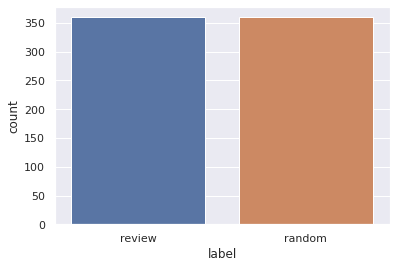

In [5]:
sns.countplot(df['label'], order=df['label'].value_counts().index);

## Divide data into training and test sets<a id='split'></a>

In [6]:
#randomize our rows
df = df.sample(720, random_state=0)

In [7]:
#create two new dataframes
df_train = df[:500]
df_test = df[500:]
df_train['label'].value_counts()

random    254
review    246
Name: label, dtype: int64

## Vectorize texts<a id='vectorize'></a>

In [8]:
#transform the 'body' column into a document term matrix
countvec = CountVectorizer(stop_words = 'english', min_df = 1, binary=True)

training_dtm_tf = countvec.fit_transform(df_train.body)
test_dtm_tf = countvec.transform(df_test.body)

#create an array for labels
training_labels = df_train.label
test_labels = df_test.label
test_labels.value_counts()

review    114
random    106
Name: label, dtype: int64

# Classification with supervised machine learning<a id='supervised'></a>

## Train logistic classifier model<a id='model'></a>

In [9]:
#define a container for our chosen algorithm, in this case logistic regression
#one object contains all the functions for fitting data, making predictions, and storing parameters
logit = LogisticRegression(solver='liblinear')

#fit a model on our training set
logit.fit(training_dtm_tf, training_labels)

#predict the labels on the test set using the trained model
predictions_logit = logit.predict(test_dtm_tf) 

In [10]:
accuracy_score(predictions_logit, test_labels)

0.7681818181818182

### Challenge

Text vectorization methods affect downstream classification accuracy. Above, we used simple term counts to turn texts into numbers. This time, instead of using term frequencies, use `sklearn`'s `TfidfVectorizer()` function to weight features with term frequency inverse document frequency (TF-IDF): this gives a word greater weight both when it is more frequent in a text AND when it is rare across the corpus. Does this vectorization approach improve classification accuracy?

In [11]:
# solution
tfidfvec = TfidfVectorizer(stop_words = 'english', min_df = 1, binary=True)
training_dtm_tfidf = tfidfvec.fit_transform(df_train.body)
test_dtm_tfidf = tfidfvec.transform(df_test.body)

logit = LogisticRegression(solver='liblinear')
logit.fit(training_dtm_tfidf, training_labels)
predictions_tfidf = logit.predict(test_dtm_tfidf) 
accuracy_score(predictions_tfidf, test_labels)

0.75

Unfortunately, TF-IDF seems to make our logistic regression classifier less accurate. So let's stick with term frequencies as our text vectorization method.

### Challenge

A common practice in machine learning is to quickly try a bunch of algorithms, see which one works the best, and optimize it. In this spirit...

**Part 1**

Apply these two additional algorithms without bothering to learn how they work: 
- Linear Support Vector Classification (`LinearSVC()`) and 
- Multinomial Naive Bayes (`MultinomialNB()`)
    
To avoid a long delay, with `LinearSVC()` set `max_iter` to 30. 

Train each of these on the training set and evaluate accuracy on the test set.

In [12]:
# solution
svc = LinearSVC(max_iter=30) #dual = False, loss='hinge'
svc.fit(training_dtm_tf, training_labels)
predictions_svc = svc.predict(test_dtm_tf) 
accuracy_score(predictions_svc, test_labels)

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.7636363636363637

In [13]:
nb = MultinomialNB()
nb.fit(training_dtm_tf, training_labels)
predictions_nb = nb.predict(test_dtm_tf) 
accuracy_score(predictions_nb, test_labels)

0.7272727272727273

**Part 2**

Try to improve the accuracy of either of these models by changing a few model parameters or the vectorizer function. (Decreases in accuracy are also informative.) This is basically a brute-force method of model optimization, which we'll learn more about tomorrow.

In [14]:
# solution
svc = LinearSVC(max_iter=100, dual = False) #loss='hinge'
svc.fit(training_dtm_tf, training_labels)
predictions_svc = svc.predict(test_dtm_tf) 
accuracy_score(predictions_svc, test_labels)

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.7681818181818182

## Prediction on new data<a id='prediction'></a>

In [15]:
dickinson_canonic = """Because I could not stop for Death – 
He kindly stopped for me –  
The Carriage held but just Ourselves –  
And Immortality.

We slowly drove – He knew no haste
And I had put away
My labor and my leisure too,
For His Civility – 

We passed the School, where Children strove
At Recess – in the Ring –  
We passed the Fields of Gazing Grain –  
We passed the Setting Sun – 

Or rather – He passed us – 
The Dews drew quivering and chill – 
For only Gossamer, my Gown – 
My Tippet – only Tulle – 

We paused before a House that seemed
A Swelling of the Ground – 
The Roof was scarcely visible – 
The Cornice – in the Ground – 

Since then – ‘tis Centuries – and yet
Feels shorter than the Day
I first surmised the Horses’ Heads 
Were toward Eternity – """


anthem_patriotic = """O! say can you see, by the dawn's early light,
What so proudly we hailed at the twilight's last gleaming,
Whose broad stripes and bright stars through the perilous fight,
O'er the ramparts we watched, were so gallantly streaming?
And the rockets' red glare, the bombs bursting in air,
Gave proof through the night that our flag was still there;
O! say does that star-spangled banner yet wave
O'er the land of the free and the home of the brave?"""

In [16]:
# Transform these into DTMs with the same feature-columns as previously
unknown_dtm = countvec.transform([dickinson_canonic,anthem_patriotic]).toarray()

In [17]:
# Return binary classification
logit.predict(unknown_dtm)

array(['review', 'random'], dtype=object)

In [18]:
# Return probability of classification. 
# Bayes theorem assigns a probability of membership in either category.
# Just how confident is our classifier of its predictions?

logit.predict_proba(unknown_dtm)

array([[0.36267018, 0.63732982],
       [0.68004536, 0.31995464]])

In [19]:
#Let's zip this together with the name of the poems to make sense of the output
list(zip(['dickinson', 'anthem'], logit.predict(unknown_dtm), logit.predict_proba(unknown_dtm)))

[('dickinson', 'review', array([0.36267018, 0.63732982])),
 ('anthem', 'random', array([0.68004536, 0.31995464]))]

### Challenge

Import and process the 'canonic' (albeit unreviewed) volumes of poetry. Use the poetry classifier to predict whether they might have been reviewed.

What do you think of the output? Does it make sense?

In [20]:
# solutions
canonic_path = 'poems/canonic/'
canonic_files = os.listdir(canonic_path)
print(canonic_files)

canonic_texts = [open(canonic_path+file_name, encoding='utf-8').read() for file_name in canonic_files]

['256 Hopkins, Gerard Manley Poems of Gerard Manley Hopkins 1889.txt', '486 Dickinson, Emily Poems 1866.txt', '12 Lawrence, D. H. Look! We Have Come Through 1918.txt', '177 Hardy, Thomas Wessex Poems 1898.txt', '0 Lawrence, D. H. Tortoises 1921.txt', '169 Dunbar, Paul Laurence Lyrics of the Hearthside 1899.txt', '593 Brontë, Emily Poems of Acton, Currer, and Ellis Bell 1848.txt', '427 Harper, Frances Ellen Watkins Poems 1871.txt']


In [21]:
canonic_dtm = countvec.transform(canonic_texts).toarray()
logit.predict(canonic_dtm)

array(['review', 'review', 'review', 'review', 'review', 'review',
       'review', 'random'], dtype=object)

In [22]:
logit.predict_proba(canonic_dtm)

array([[0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.58073567e-07, 9.99999842e-01],
       [6.60301436e-09, 9.99999993e-01],
       [8.50025617e-09, 9.99999991e-01],
       [8.36566983e-01, 1.63433017e-01]])

In [23]:
list(zip(canonic_files, logit.predict(canonic_dtm), logit.predict_proba(canonic_dtm)))

[('256 Hopkins, Gerard Manley Poems of Gerard Manley Hopkins 1889.txt',
  'review',
  array([0., 1.])),
 ('486 Dickinson, Emily Poems 1866.txt', 'review', array([0., 1.])),
 ('12 Lawrence, D. H. Look! We Have Come Through 1918.txt',
  'review',
  array([0., 1.])),
 ('177 Hardy, Thomas Wessex Poems 1898.txt', 'review', array([0., 1.])),
 ('0 Lawrence, D. H. Tortoises 1921.txt',
  'review',
  array([1.58073567e-07, 9.99999842e-01])),
 ('169 Dunbar, Paul Laurence Lyrics of the Hearthside 1899.txt',
  'review',
  array([6.60301436e-09, 9.99999993e-01])),
 ('593 Brontë, Emily Poems of Acton, Currer, and Ellis Bell 1848.txt',
  'review',
  array([8.50025617e-09, 9.99999991e-01])),
 ('427 Harper, Frances Ellen Watkins Poems 1871.txt',
  'random',
  array([0.83656698, 0.16343302]))]

## Identify features<a id='features'></a>

In [24]:
nb = MultinomialNB() # naive bayes works best for this math
nb.fit(training_dtm_tf, training_labels) # fit model

def most_informative_features(text_class, vectorizer = countvec, classifier = nb, top_n = 20):
    """Returns feature name and odds ratio for a given class"""

    feature_names = vectorizer.get_feature_names()
    class_index = np.where(classifier.classes_==(text_class))[0][0]
    
    class_prob_distro = np.exp(classifier.feature_log_prob_[class_index])
    alt_class_prob_distro = np.exp(classifier.feature_log_prob_[1 - class_index])
    
    odds_ratios = class_prob_distro / alt_class_prob_distro
    odds_with_fns = sorted(zip(odds_ratios, feature_names), reverse = True)
    
    return odds_with_fns[:top_n]

### Challenge

Look at the top thirty informative words for our reviewed and random poems. 

What kinds of patterns do you notice?

In [25]:
# solutions
most_informative_features('review', top_n=30)

[(14.861096357476907, 'yews'),
 (14.39668709630576, 'braids'),
 (13.932277835134602, 'unlighted'),
 (13.003459312792291, 'persephone'),
 (12.074640790449976, 'blurring'),
 (11.145822268107672, 'unbreathed'),
 (11.145822268107672, 'shambles'),
 (11.145822268107672, 'palimpsest'),
 (11.145822268107672, 'easeful'),
 (10.217003745765371, 'whetting'),
 (10.217003745765371, 'unrolling'),
 (10.217003745765371, 'piazza'),
 (10.217003745765371, 'overwrought'),
 (10.217003745765371, 'mouthpiece'),
 (10.217003745765371, 'exhalation'),
 (10.217003745765371, 'bigelow'),
 (9.288185223423072, 'wherefrom'),
 (9.288185223423058, 'unshamed'),
 (9.288185223423058, 'unrestful'),
 (9.288185223423058, 'uncut'),
 (9.288185223423058, 'unbearable'),
 (9.288185223423058, 'shrewish'),
 (9.288185223423058, 'sacristan'),
 (9.288185223423058, 'nighest'),
 (9.288185223423058, 'maenads'),
 (9.288185223423058, 'foliaged'),
 (9.288185223423058, 'belfries'),
 (9.288185223423058, 'austerely'),
 (8.823775962251908, 'wildi

In [26]:
most_informative_features('random', top_n=30)

[(13.996275577296228, 'minnie'),
 (12.919638994427288, 'instructions'),
 (12.919638994427288, 'acrostic'),
 (11.843002411558354, 'undertook'),
 (11.843002411558354, 'ke'),
 (11.843002411558354, 'indulging'),
 (11.843002411558354, 'frien'),
 (11.843002411558354, 'debase'),
 (11.843002411558354, 'alcohol'),
 (10.766365828689404, 'wrang'),
 (10.766365828689404, 'mell'),
 (10.766365828689404, 'investigation'),
 (10.766365828689404, 'fou'),
 (10.766365828689404, 'arranging'),
 (10.766365828689404, 'alane'),
 (9.689729245820475, 'weans'),
 (9.689729245820475, 'virus'),
 (9.689729245820475, 'velvety'),
 (9.689729245820475, 'val'),
 (9.689729245820475, 'propelled'),
 (9.689729245820475, 'legislative'),
 (9.689729245820475, 'ib'),
 (9.689729245820475, 'fulton'),
 (9.689729245820475, 'augmented'),
 (9.68972924582046, 'digression'),
 (9.151410954386009, 'insure'),
 (9.151410954386009, 'ag'),
 (8.613092662951532, 'extolled'),
 (8.613092662951532, 'bj'),
 (8.61309266295153, 'waur')]